# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.    


**ЗАДАЧА:** Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.     

**ОПИСАНИЕ ДАННЫХ:** В нашем распоряжении датасет, состоящий из *возраста людей* и *фотографии людей*.    

**ПЛАН ПРОЕКТА:**
* Провести исследовательский анализ данных
* Обучить модель
* Провестим анализ модели    

**ТРЕБОВАНИЯ К МОДЕЛИ:** Погрешность модели по метрике **MAE** не должна превышать значения **8**.

## Исследовательский анализ данных

In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Загружаем данные
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
# Посмотрим таблицу данных
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [ ]:
# Посмотрим на размерность таблицы
labels.shape

(7591, 2)

Датафрейм состоить из двух столбцов(**file_name** - название файла с изображением, **real_ag** - значения с возрастом покупателя на изображении) и 7591 строк данных.

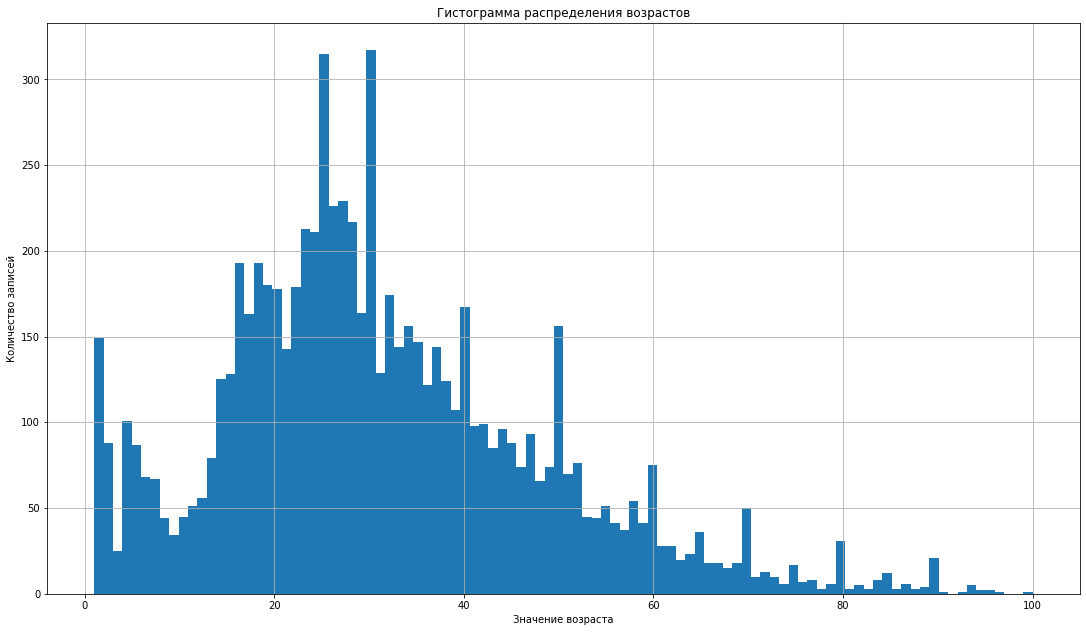

In [ ]:
# Посмотрим на гистограмму возрастов покупателей
h = labels['real_age'].hist(bins=100)
fig = h.get_figure()
fig.set_size_inches(18.5, 10.5)
plt.title('Гистограмма распределения возрастов')
plt.xlabel('Значение возраста')
plt.ylabel('Количество записей');

In [ ]:
# Охарактеризуем данные о возрасте покупателей
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Минимальный возраст - 1 год, максимальный возраст - 100 лет. Скорее всего данные являются выбросами, но судя по гистограмме количество выбросов не значительно. Основной разброс возврастов от 20 до 41. Перевес в распределении возрастов может вызвать переобучение модели на часто встречающихся возрастных группах и низкую точность предсказаний для более редких групп возрастов. Стоит учесть это при построении модели.

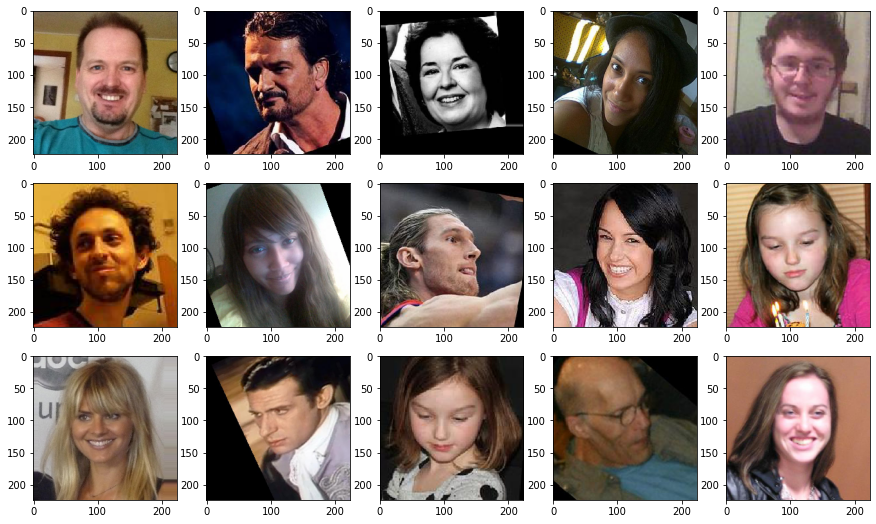

In [ ]:
# Посмотрим на случайные 15 изображений
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()
for i in range(15):
    img, age = train_gen_flow.next()
    axes[i].imshow(img[0])
plt.show()

* Все лица на фотографиях расположены прямо, аугментация по повороту изображений не требуется. Это хорошо, потому что иначе это могло бы понизить качество модели, а так же усложнить модель.
* Присутствуют фотографии, где искуственно отцентрованы лица, возможно аугментация не понадобится.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def load_train(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True,
        vertical_flip=True
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training'
    )
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        target_size=(224, 224),
        x_col='file_name',
        y_col='real_age',
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation'
    )
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 77s - loss: 12.0723 - mae: 12.0671 - val_loss: 26.2362 - val_mae: 26.2491
Epoch 2/10
178/178 - 45s - loss: 8.0977 - mae: 8.0973 - val_loss: 20.5733 - val_mae: 20.5412
Epoch 3/10
178/178 - 45s - loss: 7.3099 - mae: 7.3101 - val_loss: 14.4300 - val_mae: 14.3994
Epoch 4/10
178/178 - 45s - loss: 6.7103 - mae: 6.7101 - val_loss: 9.3054 - val_mae: 9.2949
Epoch 5/10
178/178 - 45s - loss: 6.1717 - mae: 6.1719 - val_loss: 9.0281 - val_mae: 9.0290
Epoch 6/10
178/178 - 45s - loss: 5.8939 - mae: 5.8943 - val_loss: 7.2613 - val_mae: 7.2677
Epoch 7/10
178/178 - 45s - loss: 5.6198 - mae: 5.6200 - val_loss: 7.4791 - val_mae: 7.5025
Epoch 8/10
178/178 - 45s - loss: 5.3461 - mae: 5.3464 - val_loss: 6.9520 - val_mae: 6.9674
Epoch 9/10
178/178 - 45s - loss: 5.1708 - mae: 5.1711 - val_loss: 6.6758 - val_mae: 6.7005
Epoch 10/10
178/178 - 45s - loss: 4.9322 - mae: 4.9325 - val_loss: 6.3873 - val_mae: 6.4108

60/60 - 11s - loss: 6.3873 - mae: 6.4108

```

## Анализ обученной модели

Для построения модели была выбрана свёрточная нейронная сеть ResNet50. На 10 эпохах модель показала лучший результат MAE=6.4108 на валидационной выборке. При построении модели были выставлены следующие параметры:
* При загрузке данных была использована аугментация: горизонтальное и вертикальное отражение.
* ResNet50 адаптирована под нашу задачу:
  * Убрана верхушка;
  * Веса использованы с сервера для более быстрого обучения модели;
  * Слои ResNet50 не заморожены;
  * Добавлена собственная верхушка с активацией нейронов *linear*;
  * Параметры оптимизированы при помощи Adam с lr = 0.0001.
  
Согласно требованиям заказчика показания метрики MAE должно быть меньше 8, значит наша модель полностью удовлетворяет требования.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы